In [74]:
# Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf #https://pypi.org/project/yfinance/
from pytickersymbols import PyTickerSymbols # https://pypi.org/project/pytickersymbols/
from scipy.stats import uniform
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import pareto
from scipy.optimize import minimize
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

In [102]:
# Functions and classes

class plotting:
    '''
    Class for plotting. 
    '''
    def __init__(self,ax,myxlabel,myylabel,font_sizes,leg):
        self.ax = ax # Axis
        self.myxlabel = myxlabel # x-label
        self.myylabel = myylabel # y-label
        self.font_sizes = font_sizes # font-sizes 
        self.leg = leg # Legend 

    def add_labels(self):
        '''
        Adds labels, grid and optional legend to plot.
        Inputs: 
        ax - plotting object
        myxlabel - xlabel string
        myylabel - ylabel string
        font_sizes - array of size 5 of fontsizes for xlabel string, 
        ylabel string, xticks, yticks and legend
        leg - if 1 put in the legend, otherwise do not
        Output: ax - plotting object with the added inputs
        '''
        self.ax.set_xlabel(self.myxlabel,fontsize=self.font_sizes[0])
        self.ax.set_ylabel(self.myylabel,fontsize=self.font_sizes[1])
        self.ax.grid(color='grey', linestyle='--', linewidth=0.5)
        self.ax.tick_params(axis='x', labelsize=self.font_sizes[2])
        self.ax.tick_params(axis='y', labelsize=self.font_sizes[3])
        if(self.leg==1):
            self.ax.legend(fontsize=self.font_sizes[4])
        return self.ax

class return_functions:
    
     def __init__(self,stock_prices):
        self.stock_prices = stock_prices

     def get_index_array(self):
        '''
        This function outputs array that indexes only 
        to the not nans in the stock prices. MAY NOT BE NECESSARY
        '''
        ind_not_nan=np.where(np.isnan(self.stock_prices)==False)[0]
        return ind_not_nan

     def returns(self):
        '''
        Finds returns of array of stock prices.
        Input: stock prices object
        Output: float array of returns
        '''
        ind_not_nan = self.get_index_array()
        stock_prices_f=np.asarray(self.stock_prices[ind_not_nan],float) 
        return stock_prices_f[1:]/stock_prices_f[:-1]
    
     def log_returns(self):
        '''
        Finds log returns of array of stock prices.
        See https://gregorygundersen.com/blog/2022/02/06/log-returns/
        Input: stock prices object
        Output: float array of log returns
        '''
        returns = self.returns()
        return np.log(returns)

def get_stock_prices_dates(data):
    '''
    Inputs: data - dataframe of stock
    Outputs: dates of stock, time interval of stocks in years, stock prices
    '''
    # Get dates which is the index column of the data frame
    data['Date']=data.index
    dates=data['Date']
    
    # Get number of years of historic stock data
    start_date = dates.iloc[0]
    end_date = dates.iloc[-1]
    difference_in_years = relativedelta(end_date, start_date).years
    
    # Stock prices as float
    stock_type = 'Close'
    stock_prices = np.asarray(data[stock_type],float)

    return dates, difference_in_years, stock_prices

def plot_stock_info(data,stock):
    '''
    Inputs: data - dataframe of stock, stock - stock code.
    Outputs: plot the stock price, returns and log returns.
    '''

    dates, difference_in_years, stock_prices =  get_stock_prices_dates(data)
    stock_type = 'Close'
    
    returns_c = return_functions(stock_prices) # Enter stock-prices to returns class
    returns = returns_c.returns() # Get log-returns
    log_returns = returns_c.log_returns() # Get log-returns
    

    # Plot historical daily (closed) stock price, log returns and k-generalised and normal fits to tails of log returns ##############
    fig, ax = plt.subplots(1,2,figsize=(10,3)) 

    if difference_in_years <= 10:
        ax[0].xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
        ax[1].xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
    
    ax[0].plot(dates,stock_prices,label=stock+' '+stock_type)
    font_sizes = [10,10,10,10,12]
    leg=1
    labels=['Date','Stock price',font_sizes,leg]
    plotting(ax[0],*labels).add_labels()
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Set dates to year only for x-axis
    
    ax[1].plot(dates[1:],log_returns,label=stock)
    leg=0
    labels=['Date','Log-Returns',font_sizes,leg]
    plotting(ax[1],*labels).add_labels()
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Set dates to year only for x-axis 
    
    plt.tight_layout()

def k_stat(l):
    '''
    Input log-returns
    Output K-statistic
    '''
    l_p = l[l>0]
    l_np = l[l<=0]
    p_p = len(l_p)/len(l)
    p_np = len(l_np)/len(l)
    e_p = np.mean(l_p)
    e_np = np.abs(np.mean(l_np))
    
    k = (p_p*e_p)/(p_np*e_np)
    return k

def k_returns_time(range_min,stock_prices,log_returns):
    '''
    Input stock prices and log-returns of a stock.
    Output the k-statistics and returns of the stock over time starting from range_min stock values.
    '''
    k_stats = []
    returns_t = []

    for i in range(range_min,len(stock_prices)):
        k = k_stat(log_returns[:i])
        r = stock_prices[i]/stock_prices[0]
        k_stats.append(k)
        returns_t.append(r)
    return k_stats, returns_t

def up_down(x,m):
    '''
    Input array x of values and a value m. 
    Output array of 0,1s with 0 if value <= m and 1 if value > m.
    '''
    n = len(x)
    ud = np.zeros(n)
    for i in range(n):
        if x[i] > m:
            ud[i] = 1
    ud = np.asarray(ud,int)
    return ud

def get_no_runs(d):
    '''
    Input an array d of 0-1s.
    Output number of runs.
    '''
    n = len(d)
    n_runs = 1

    for i in range(n-1):
        if d[i] != d[i+1]:
            n_runs += 1

    return n_runs
    

def wald_wolfowitz_runs_test(d):
    '''
    https://www.itl.nist.gov/div898/handbook/eda/section3/eda35d.html
    Input an array d of 0-1s.
    Output the p-value of the Wald-Wolfowitz runs test.
    '''
    n = len(d)
    n1 = np.sum(d)
    n2 = n - n1

    n_runs =  get_no_runs(d)       

    mu = (2*n1*n2)/(n1+n2)+1
    var = ((2*n1*n2)*(2*n1*n2-n1-n2))/((n1+n2)**2*(n1+n2-1))
    sigma = var**0.5
    z = (n_runs-mu)/sigma
    
    if z<0:
        s = norm.cdf(z)
    else:
        s = norm.sf(z)

    return s

class autocorrelation:
    
    def autocorrelation_k(x,k):
        '''
        Inputs: x: array of observed time series values, k: lag
        Output: autocorrelation at lag k
        '''
        n = len(x)
        x_bar = np.mean(x)
        c_0 = np.sum((x - x_bar)**2)
        c_k = np.sum((x[:n-k] - x_bar)*(x[k:] - x_bar))
        return c_k/c_0

    def correlogram(x):
        '''
        Inputs: x: array of observed time series values of length n
        Outputs: lags k=1,2,...,n-1, autocorrelations at lag k
        '''
        n = len(x)
        ks = np.arange(1,n,1)
        rks = []
        for k in ks:
            rks.append(autocorrelation.autocorrelation_k(x,k))
        rks = np.asarray(rks,float)
        return ks, rks

    def sig_lags(x,k):
        n = len(x)
        lags, autocorrelations = autocorrelation.correlogram(d)
        c_01 = norm.isf(0.005)
        s1 = -1/n-c_01/np.sqrt(n)
        s2 = -1/n+c_01/np.sqrt(n)
        ind = np.where((autocorrelations<s1) | (autocorrelations>s2))[0] 
        lags1 = lags[ind]
        return lags1[lags1<=k]

    def plot_correlogram(x,k):
        '''
        Plot correlogram of time series x
        '''
        n = len(x)
        lags, autocorrelations = autocorrelation.correlogram(x)
    
        c_05 = norm.isf(0.025)
        c_01 = norm.isf(0.005)
        
    
        fig, ax = plt.subplots(figsize=(5,3))
   
        ax.plot(np.asarray(lags,int),autocorrelations,'-o')
        ax.hlines(y=-1/n+c_05/np.sqrt(n),xmin=min(lags), xmax=max(lags),color='black') # 95% CI lower bound
        ax.hlines(y=-1/n-c_05/np.sqrt(n),xmin=min(lags), xmax=max(lags),color='black') # 95% CI upper bound
        ax.hlines(y=-1/n+c_01/np.sqrt(n),xmin=min(lags), xmax=max(lags),color='black') # 99% CI lower bound
        ax.hlines(y=-1/n-c_01/np.sqrt(n),xmin=min(lags), xmax=max(lags),color='black') # 99% CI upper bound
        ax.set_xlim([0, k])
        leg = 0
        font_sizes = [10,10,10,10,12]
        labels=[r'$k$',r'$r_k$',font_sizes,leg]
        plotting(ax,*labels).add_labels()
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
        plt.tight_layout()

# Ideas

* Various statistics on returns
* Test for randomness in returns
* Some methods for prediction - trends, machine learning
* Test prediction


# Theory

Stock value at time $t$ denoted as $S_t\,.$

Returns $R_{t,\tau}$ at time $t$ defined over some time period $\tau$

\begin{equation}
R_{t,\tau} := \frac{S_t}{S_{t-\tau}} \,.
\end{equation}

Log returns $L_{t,\tau}$ at time $t$  defined for some time period $\tau$ as log of returns

\begin{equation}
L_{t,\tau} := \log R_{t,\tau} = \log \left(\frac{S_t}{S_{t-\tau}}\right) \,.
\end{equation}

Stock value goes up over period $\tau$ if 

\begin{equation}
R_{t,\tau} >1 \Leftrightarrow L_{t,\tau} > 0 \,.
\end{equation}


## Stock statistic

Assume $R_{t,\tau}$ from some distribution. Set $R_{t,\tau} = R$ 

\begin{align}
 K &= \frac{\mathbb{P}(R >1)(\mathbb{E}[R|R>1]-1)}{\mathbb{P}(R <1)(1-\mathbb{E}[R|R<1])} \\
 &= \frac{\mathbb{P}(L >0)\mathbb{E}[L|L>0]}{\mathbb{P}(L<0)|\mathbb{E}[L|L<0]|}
\end{align}



In [3]:
'''
https://pypi.org/project/pytickersymbols/

Get ticker symbols for stocks.
'''
stock_data = PyTickerSymbols()

all_ticker_getter_names = list(filter(
   lambda x: (
         x.endswith('london_yahoo_tickers')
   ),
   dir(stock_data),
))

print(all_ticker_getter_names,'\n')

# London yahoo tickers

ftse_100_yahoo = stock_data.get_ftse_100_london_yahoo_tickers() # FTSE 100
sp_100_yahoo = stock_data.get_sp_100_london_yahoo_tickers() # S&P 100
nasdaq_100_yahoo = stock_data.get_nasdaq_100_london_yahoo_tickers() # Nasdaq 100

ftse_100_yahoo = np.asarray(ftse_100_yahoo)
sp_100_yahoo = np.asarray(sp_100_yahoo)
nasdaq_100_yahoo = np.asarray(nasdaq_100_yahoo)

['get_aex_london_yahoo_tickers', 'get_bel_20_london_yahoo_tickers', 'get_cac_40_london_yahoo_tickers', 'get_cac_mid_60_london_yahoo_tickers', 'get_cdax_london_yahoo_tickers', 'get_dax_london_yahoo_tickers', 'get_dow_jones_london_yahoo_tickers', 'get_euro_stoxx_50_london_yahoo_tickers', 'get_ftse_100_london_yahoo_tickers', 'get_ibex_35_london_yahoo_tickers', 'get_mdax_london_yahoo_tickers', 'get_moex_london_yahoo_tickers', 'get_nasdaq_100_london_yahoo_tickers', 'get_omx_helsinki_25_london_yahoo_tickers', 'get_omx_stockholm_30_london_yahoo_tickers', 'get_sdax_london_yahoo_tickers', 'get_sp_100_london_yahoo_tickers', 'get_sp_500_london_yahoo_tickers', 'get_sp_600_london_yahoo_tickers', 'get_switzerland_20_london_yahoo_tickers', 'get_tecdax_london_yahoo_tickers'] 



In [4]:
'''
Get stock data using yfinance Python package.
'''

# Stock codes:

stock = '^NYA'
# stock = '^IXIC'
# stock = '^FTSE'
# stock = 'AAPL' 
# stock = 'BTC-GBP'
# stock = 'ABNB'
# stock = 'GC=F'

data = yf.download(stock, period="max") # Dataframe for stock for maximum period. Note sometimes a stock fails to download!

[*********************100%%**********************]  1 of 1 completed


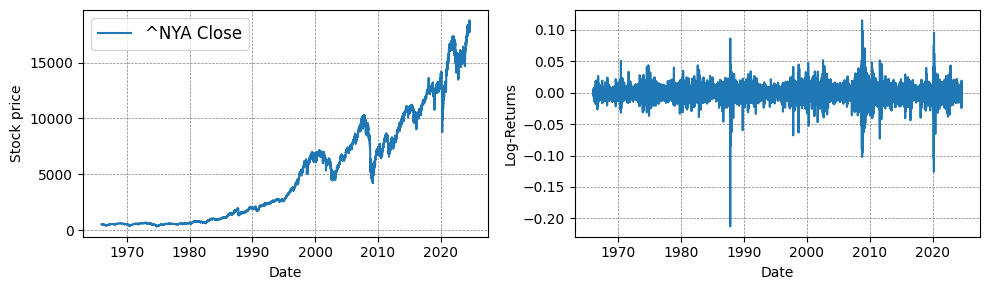

In [5]:
plot_stock_info(data,stock)

In [6]:
dates, difference_in_years, stock_prices = get_stock_prices_dates(data)
log_returns = return_functions(stock_prices).log_returns()
n = len(dates)
returns_random = uniform.rvs(size = n, loc = 0.95, scale = 0.1)
log_returns_random = np.log(returns_random)

In [7]:
print(k_stat(log_returns))

1.0729333857660783


In [8]:
m = np.median(log_returns)
d = up_down(log_returns,m)

m1 = np.median(log_returns_random)
d1 = up_down(log_returns_random,m1)

In [9]:
print(wald_wolfowitz_runs_test(d),wald_wolfowitz_runs_test(d1))

4.848456065136043e-11 0.2630516525175926


In [10]:
date_start = "2023-01-01"
date_end = "2024-01-01"

# date_start = None
# date_end = None

data = yf.download(stock, start = date_start, end = date_end)
dates, difference_in_years, stock_prices = get_stock_prices_dates(data)
log_returns = return_functions(stock_prices).log_returns()

range_min = 20
k_stats, returns_t = k_returns_time(range_min,stock_prices,log_returns)

n = len(dates)

returns_random = uniform.rvs(size = n, loc = 0.95, scale = 0.1)
log_returns_random = np.log(returns_random)

stock_prices_random = np.exp(np.cumsum(log_returns_random))

k_stats_random, returns_t_random = k_returns_time(range_min,stock_prices_random,log_returns_random)

[*********************100%%**********************]  1 of 1 completed


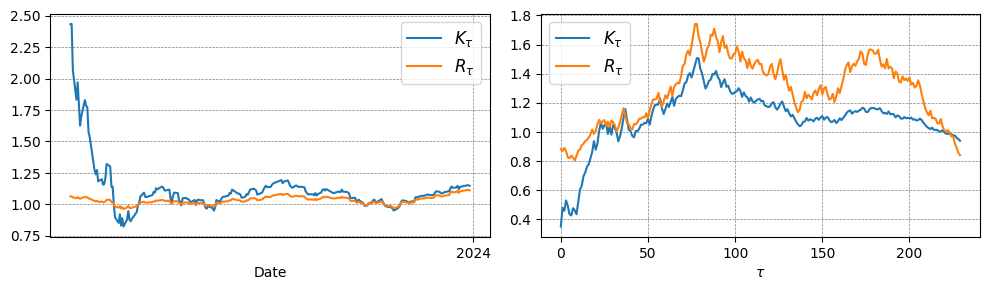

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,3)) 
ax[0].plot(dates[range_min:],k_stats,label = r'$K_{\tau}$')
ax[0].plot(dates[range_min:],returns_t,label = r'$R_{\tau}$')
if difference_in_years <= 10:
    ax[0].xaxis.set_major_locator(mdates.YearLocator(1))

font_sizes = [10,10,10,10,12]
leg=1
labels=['Date','',font_sizes,leg]
plotting(ax[0],*labels).add_labels()

ax[1].plot(k_stats_random,label = r'$K_{\tau}$')
ax[1].plot(returns_t_random,label = r'$R_{\tau}$')

font_sizes = [10,10,10,10,12]
leg=1
labels=[r'$\tau$','',font_sizes,leg]
plotting(ax[1],*labels).add_labels()

plt.tight_layout()

In [12]:
URL = "https://finance.yahoo.com/world-indices/"

world_stock_indices = []

driver = webdriver.Chrome()
driver.get(URL)

# Click scroll down
for element in driver.find_elements(By.XPATH,'//*[@id="scroll-down-btn"]'):
    driver.execute_script("arguments[0].click();", element)

# Click reject cookies - problem when loading webpage if accept cookies
for element in driver.find_elements(By.XPATH,'//*[@id="consent-page"]/div/div/div/form/div[2]/div[2]/button[2]'):
    driver.execute_script("arguments[0].click();", element)
    
# Get the world stock indices tickers
for i in range(1,37):
    for element in driver.find_elements(By.XPATH,f'//*[@id="list-res-table"]/div[1]/table/tbody/tr[{i}]/td[1]/a'):
        world_stock_indices.append(element.text)

driver.quit() # Quit the webpage

In [13]:
print(world_stock_indices)

['^GSPC', '^DJI', '^IXIC', '^NYA', '^XAX', '^BUK100P', '^RUT', '^VIX', '^FTSE', '^GDAXI', '^FCHI', '^STOXX50E', '^N100', '^BFX', 'IMOEX.ME', '^N225', '^HSI', '000001.SS', '399001.SZ', '^STI', '^AXJO', '^AORD', '^BSESN', '^JKSE', '^KLSE', '^NZ50', '^KS11', '^TWII', '^GSPTSE', '^BVSP', '^MXX', '^IPSA', '^MERV', '^TA125.TA', '^CASE30', '^JN0U.JO']


In [24]:
data_world_indices = {}
data_world_sig_indices = {}

for stock in world_stock_indices:
    data = yf.download(stock, period="max")
    dates, difference_in_years, stock_prices = get_stock_prices_dates(data)
    log_returns = return_functions(stock_prices).log_returns()
    if len(log_returns) > 100:
        m = np.median(log_returns)
        d = up_down(log_returns,m)
        s = wald_wolfowitz_runs_test(d)
        data_world_indices[stock] = s
        if s < 0.025:
            data_world_sig_indices[stock] = s
    else:
        data_world_indices[stock] = 'NA'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [30]:
world_stock_sig_indices = list(data_world_sig_indices.keys())

In [110]:
print(len(world_stock_indices), len(world_stock_sig_indices))

36 21


In [113]:
print(world_stock_indices)
print('')
print(world_stock_sig_indices)

['^GSPC', '^DJI', '^IXIC', '^NYA', '^XAX', '^BUK100P', '^RUT', '^VIX', '^FTSE', '^GDAXI', '^FCHI', '^STOXX50E', '^N100', '^BFX', 'IMOEX.ME', '^N225', '^HSI', '000001.SS', '399001.SZ', '^STI', '^AXJO', '^AORD', '^BSESN', '^JKSE', '^KLSE', '^NZ50', '^KS11', '^TWII', '^GSPTSE', '^BVSP', '^MXX', '^IPSA', '^MERV', '^TA125.TA', '^CASE30', '^JN0U.JO']

['^GSPC', '^DJI', '^IXIC', '^NYA', '^XAX', '^RUT', '^GDAXI', '^FCHI', '^STOXX50E', '^BFX', 'IMOEX.ME', '^STI', '^AORD', '^BSESN', '^JKSE', '^KLSE', '^NZ50', '^GSPTSE', '^MXX', '^IPSA', '^MERV']


In [128]:
i = 0
# stock = world_stock_sig_indices[i]
stock = 'DARK.L'
# print(stock)
# data = yf.download(stock, period="max")
date_start = "2022-04-26"
# date_end = "2024-01-01"

# date_start = None
date_end = None

data = yf.download(stock, start = date_start, end = date_end)
dates, difference_in_years, stock_prices = get_stock_prices_dates(data)
log_returns = return_functions(stock_prices).log_returns()
m = np.median(log_returns)
d = up_down(log_returns,m)

[*********************100%%**********************]  1 of 1 completed


array([], dtype=int64)

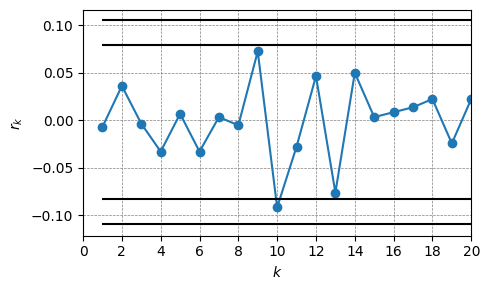

In [129]:
autocorrelation.plot_correlogram(d,20)
autocorrelation.sig_lags(d,20)

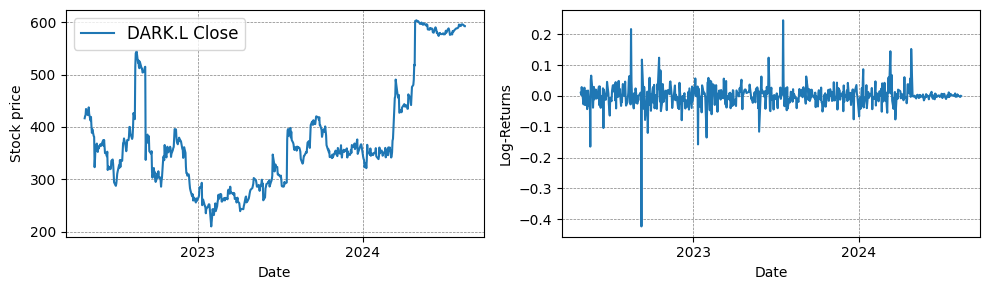

In [130]:
plot_stock_info(data,stock)